In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers

%matplotlib inline

In [3]:
#start=dt.datetime(2015,1,1)
#end=dt.datetime(2015,1,5)
dateslist=[[dt.datetime(2015,1,1),dt.datetime(2015,1,5)],
           [dt.datetime(2015,1,5),dt.datetime(2015,1,10)],
           [dt.datetime(2015,1,10),dt.datetime(2015,1,15)]]
year=str(dateslist[0][0].year)
modver='201812'
loc='S3'

#savedir='/ocean/aisabell/MEOPAR/extracted_files'
savedir='/ocean/eolson/MEOPAR/'

fname=f'testJanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
fname2=f'testJanToMarch_TimeSeries_{year}_{modver}.pkl' # for non-location specific variables
savepath=os.path.join(savedir,fname)
savepath2=os.path.join(savedir,fname2)
recalc=False

In [6]:
dateslist

[[datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2015, 1, 5, 0, 0)],
 [datetime.datetime(2015, 1, 5, 0, 0), datetime.datetime(2015, 1, 10, 0, 0)],
 [datetime.datetime(2015, 1, 10, 0, 0), datetime.datetime(2015, 1, 15, 0, 0)]]

In [7]:
for el in dateslist:
    print(el)

[datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2015, 1, 5, 0, 0)]
[datetime.datetime(2015, 1, 5, 0, 0), datetime.datetime(2015, 1, 10, 0, 0)]
[datetime.datetime(2015, 1, 10, 0, 0), datetime.datetime(2015, 1, 15, 0, 0)]


1.1363636363636362

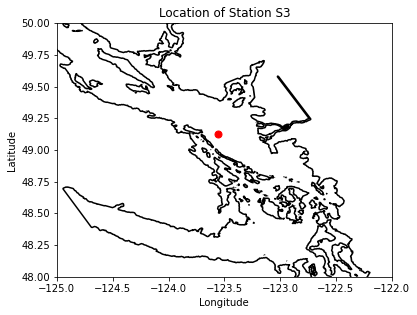

In [5]:
loc='S3'

# lat and lon informatin for place:
lon,lat=places.PLACES['S3']['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES['S3']['NEMO grid ji']
# GEM2.5 grid ji is atm forcing grid for ops files
jw,iw=places.PLACES['S3']['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station S3')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

In [21]:
if recalc==True or not os.path.isfile(savepath):
    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    bio_time=list()
    diat_alld=list()
    no3_alld=list()
    flag_alld=list()
    cili_alld=list()
    microzoo_alld=list()
    mesozoo_alld=list()
    intdiat=list()
    intphyto=list()
    spar=list()
    intmesoz=list()
    intmicroz=list()
    grid_time=list()
    temp=list()
    salinity=list()
    u_wind=list()
    v_wind=list()
    twind=list()
    solar=list()
    ik=0
    for ind, datepair in enumerate(dateslist):
        start=datepair[0]
        end=datepair[1]
        flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
        flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
        fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)
        with xr.open_mfdataset(flist['paths']) as bio:
            bio_time.append(np.array(bio.time_centered[:]))
            no3_alld.append(np.array(bio.nitrate.isel(y=ij,x=ii)) )
            diat_alld.append(np.array(bio.diatoms.isel(y=ij,x=ii)))
            flag_alld.append(np.array(bio.flagellates.isel(y=ij,x=ii)))
            cili_alld.append(np.array(bio.ciliates.isel(y=ij,x=ii)))
            microzoo_alld.append(np.array(bio.microzooplankton.isel(y=ij,x=ii)))
            mesozoo_alld.append(np.array(bio.mesozooplankton.isel(y=ij,x=ii)))

            with xr.open_mfdataset(fliste3t['paths']) as carp:
                intdiat.append(np.array(np.sum(bio.diatoms.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1))) # depth integrated diatom
                intphyto.append(np.array(np.sum((bio.diatoms.isel(y=ij,x=ii)+bio.flagellates.isel(y=ij,x=ii)\
                                +bio.ciliates.isel(y=ij,x=ii))*carp.e3t.isel(y=ij,x=ii),1)))
                spar.append(np.array(carp.PAR.isel(deptht=ik,y=ij,x=ii)))
                intmesoz.append(np.array(np.sum(bio.mesozooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))
                intmicroz.append(np.array(np.sum(bio.microzooplankton.isel(y=ij,x=ii)*carp.e3t.isel(y=ij,x=ii),1)))

        with xr.open_mfdataset(flist3['paths']) as grid:
            grid_time.append(np.array(grid.time_centered[:]))
            temp.append(np.array(grid.votemper.isel(deptht=ik,y=ij,x=ii)) )#surface temperature
            salinity.append(np.array(grid.vosaline.isel(deptht=ik,y=ij,x=ii))) #surface salinity

        opsdir='/results/forcing/atmospheric/GEM2.5/operational'

        flist2=et.index_model_files(start,end,opsdir,nam_fmt='ops',flen=1,ftype='None',tres=24)
        with xr.open_mfdataset(flist2['paths']) as winds:
            u_wind.append(np.array(winds.u_wind.isel(y=jw,x=iw)))
            v_wind.append(np.array(winds.v_wind.isel(y=jw,x=iw)))
            twind.append(np.array(winds.time_counter))
            solar.append(np.array(winds.solar.isel(y=jw,x=iw)))
    
    bio_time=np.concatenate(bio_time,axis=0)
    diat_alld=np.concatenate(diat_alld,axis=0)
    no3_alld=np.concatenate(no3_alld,axis=0)
    flag_alld=np.concatenate(flag_alld,axis=0)
    cili_alld=np.concatenate(cili_alld,axis=0)
    microzoo_alld=np.concatenate(microzoo_alld,axis=0)
    mesozoo_alld=np.concatenate(mesozoo_alld,axis=0)
    intdiat=np.concatenate(intdiat,axis=0)
    intphyto=np.concatenate(intphyto,axis=0)
    spar=np.concatenate(spar,axis=0)
    intmesoz=np.concatenate(intmesoz,axis=0)
    intmicroz=np.concatenate(intmicroz,axis=0)
    grid_time=np.concatenate(grid_time,axis=0)
    temp=np.concatenate(temp,axis=0)
    salinity=np.concatenate(salinity,axis=0)
    u_wind=np.concatenate(u_wind,axis=0)
    v_wind=np.concatenate(v_wind,axis=0)
    twind=np.concatenate(twind,axis=0)
    solar=np.concatenate(solar,axis=0)
    allvars=(bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar)
    pickle.dump(allvars,open(savepath,'wb'))
else:
    pvars=pickle.load(open(savepath,'rb'))
    (bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,
              intdiat,intphyto,spar,intmesoz,intmicroz,
            grid_time,temp,salinity,u_wind,v_wind,twind,solar)=pvars

In [8]:
basedir='/results/SalishSea/nowcast-green.201812/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution  
flist=et.index_model_files(dt.datetime(2015,1,1),dt.datetime(2015,1,5),basedir,nam_fmt,flen,ftype,tres)

In [9]:
test = xr.open_mfdataset(flist['paths'])

In [11]:
v1=np.array(test.nitrate.isel(y=ij,x=ii)) 

In [12]:
v2=np.array(test.time_centered[:])

In [19]:
test2=dict()
test2[0]=v1
test2[1]=v1

(4,)

In [16]:
v1b=np.concatenate((v1,v1),axis=0)

In [17]:
np.shape(v1b)

(8, 40)

In [18]:
np.shape(np.concatenate((v2,v2),axis=0))

(8,)

In [18]:
### calculations based on saved values
no3_30to90m=np.sum(no3_alld[:,22:26]*e3t_0[:,22:26,ij,ii],1)/np.sum(e3t_0[:,22:26,ij,ii]) # average, considering cell thickness
sno3=no3_alld[:,0]
sdiat=diat_alld[:,0]
sflag=flag_alld[:,0]
scili=cili_alld[:,0]
intzoop=intmesoz+intmicroz
fracdiat=intdiat/intphyto # depth integrated fraction of diatoms
zoop_alld=microzoo_alld+mesozoo_alld
sphyto=sdiat+sflag+scili
phyto_alld=diat_alld+flag_alld+cili_alld
percdiat=sdiat/sphyto # fraction surface diatoms

# wind speed:
wspeed=np.sqrt(u_wind**2 + v_wind**2)
# wind direction in degrees from east
d = np.arctan2(v_wind, u_wind)
winddirec=np.rad2deg(d + (d < 0)*2*np.pi)

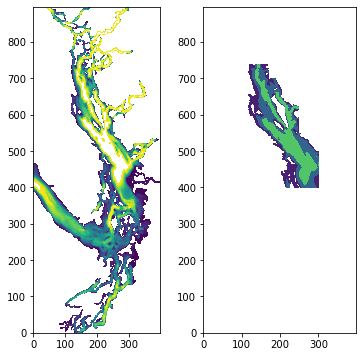

In [19]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

In [20]:
for ind,z in enumerate(gdept_1d[0]):
    print(ind,z)

0 0.5000002726327963
1 1.5000031443492432
2 2.5000115035531536
3 3.500030550916236
4 4.500070415944791
5 5.500150828149344
6 6.500310215091616
7 7.500623422387349
8 8.501236225390784
9 9.502432540550814
10 10.504765304051489
11 11.509311270243131
12 12.518166842463359
13 13.535412118866162
14 14.568982157803276
15 15.634287368141315
16 16.761173418470406
17 18.00713455587004
18 19.48178513731196
19 21.38997868353431
20 24.10025665445164
21 28.229915135962585
22 34.68575798315476
23 44.51772486309295
24 58.4843336842095
25 76.58558444650436
26 98.06295924154529
27 121.86651840226745
28 147.08945807358322
29 173.11448216959397
30 199.57304923038515
31 226.26030573521862
32 253.06663732712263
33 279.9345497590177
34 306.8341973623137
35 333.750169728144
36 360.67453179815686
37 387.60320347419827
38 414.5340883529307
39 441.4661096800038


In [21]:
### loops that are not location specific (do not need to be redone for each location):
k250=32 # approximate index for 250 m
if recalc==True or not os.path.isfile(savepath2):

    basedir='/results/SalishSea/nowcast-green.201812/'
    nam_fmt='nowcast'
    flen=1 # files contain 1 day of data each
    ftype= 'ptrc_T' # load bio files
    tres=24 # 1: hourly resolution; 24: daily resolution  
    flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
    flist3 = et.index_model_files(start,end,basedir,nam_fmt,flen,"grid_T",tres)
    fliste3t = et.index_model_files(start,end,basedir,nam_fmt,flen,"carp_T",tres)

    ik=0
    with xr.open_mfdataset(flist['paths']) as bio:
        no3_past250m=np.array(np.sum(np.sum(np.sum(bio.nitrate.isel(deptht=slice(32,40))*sogmask[:,32:,:,:]*e3t_0[:,32:,:,:],3),2),1)\
                /np.sum(sogmask[0,32:,:,:]*e3t_0[0,32:,:,:]))
        
    # reading Fraser river flow files
    dfFra=pd.read_csv('/ocean/eolson/MEOPAR/obs/ECRivers/Flow/FraserHopeDaily__Feb-8-2021_06_29_29AM.csv',
                      skiprows=1)
    # the original file contains both flow and water level information in the same field (Value)
    # keep only the flow data, where PARAM=1 (drop PARAM=2 values, water level data)
    # flow units are m3/s
    # DD is YD, year day (ie. 1 is jan 1)
    dfFra.drop(dfFra.loc[dfFra.PARAM==2].index,inplace=True)  

    # rename 'Value' column to 'Flow' now that we have removed all the water level rows
    dfFra.rename(columns={'Value':'Flow'}, inplace=True) 
        # inplace=True does this function on the orginal dataframe

    # no time information so use dt.date
    dfFra['Date']=[dt.date(iyr,1,1)+dt.timedelta(days=idd-1) for iyr, idd in zip(dfFra['YEAR'],dfFra['DD'])]
    # taking the value from the yr column, jan1st date, and making jan1 column to be 1 not 0
    dfFra.head(2)

    # select portion of dataframe in desired date range
    dfFra2=dfFra.loc[(dfFra.Date>=start.date())&(dfFra.Date<=end.date())]
    riv_time=dfFra2['Date'].values
    rivFlow=dfFra2['Flow'].values
    # could also write dfFra['Date'], sometimes this is required
    # newstart is a datetime object, so we convert it to just a date with .date
    
    allvars=(no3_past250m,riv_time,rivFlow)
    pickle.dump(allvars,open(savepath2,'wb'))
else:
    pvars=pickle.load(open(savepath2,'rb'))
    (no3_past250m,riv_time,rivFlow)=pvars